In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite
/kaggle/input/glove-6b-100-d/glove.6B.100d.txt


In [2]:
import pandas as pd

In [3]:
dataset=pd.read_csv(r"/kaggle/input/amazon-fine-food-reviews/Reviews.csv")

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
dataset.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
print(dataset[['Score','Text']].head(5))

   Score                                               Text
0      5  I have bought several of the Vitality canned d...
1      1  Product arrived labeled as Jumbo Salted Peanut...
2      4  This is a confection that has been around a fe...
3      2  If you are looking for the secret ingredient i...
4      5  Great taffy at a great price.  There was a wid...


In [7]:
print(dataset.isna().sum())

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [8]:
lmtpData=dataset[['Text','Summary','Score']].sample(n=1000)
print(lmtpData)

                                                     Text  \
329374  This soup is in a class by itself.  The ingred...   
484157  Excellent product- has a great taste and a gre...   
115845  First off, I'll let it be known that I'm Engli...   
540486  I have tried many strengths of coffee.  The Ti...   
536330  When I first found my dog at a shelter I start...   
...                                                   ...   
564392  I have very small dogs (5 and 7 lbs) and it do...   
83187   I love this brand. If you go to their website,...   
112400  This bar is unbelievably good. The flavor and ...   
326690  I used to have the decaf Carribu coffee - but ...   
401509  These fruit snacks come in individual wrappers...   

                                    Summary  Score  
329374                       Best Soup Ever      5  
484157              Absolutely delicious!!!      5  
115845  Best Cuppa English Tea (In My Book)      5  
540486                     Delicious coffee      5  
53

### ADDING SENTIMENT COLUMN

In [9]:
#0-negative, 1-positive
def lblScore(score):
    if score<=2:
        return 0
    elif score>=4:
        return 1
    else:
        return 2
lmtpData['Sentiment']=lmtpData['Score'].apply(lblScore)
lmtpData.head(5)

,Text,Summary,Score,Sentiment
329374,This soup is in a class by itself. The ingred...,Best Soup Ever,5,1
484157,Excellent product- has a great taste and a gre...,Absolutely delicious!!!,5,1
115845,"First off, I'll let it be known that I'm Engli...",Best Cuppa English Tea (In My Book),5,1
540486,I have tried many strengths of coffee. The Ti...,Delicious coffee,5,1
536330,When I first found my dog at a shelter I start...,best dog food on the market,5,1


In [10]:
lmtpData['Sentiment'].value_counts()

Sentiment
1    775
0    131
2     94
Name: count, dtype: int64

#### VECTORS

In [11]:
import numpy as np

glove_path = "/kaggle/input/glove-6b-100-d/glove.6B.100d.txt"

def loadGloveEmbeddings(filePath, embedding_dim=100):
    embeddingsIndex = {}
    with open(filePath, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddingsIndex[word] = coefs
    return embeddingsIndex

gloveEmbeddings = loadGloveEmbeddings(glove_path)
print("Loaded {} word vectors.".format(len(gloveEmbeddings)))


        

Loaded 400000 word vectors.


#### CREATING EMBEDDING MATRIX

In [12]:
lmtpData['Summary']=lmtpData['Summary'].fillna("")
lmtpData['CombinedText']=lmtpData['Summary'] + " " + lmtpData['Text']


In [13]:
#tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer()
tokenizer.fit_on_texts(lmtpData['CombinedText'])
sequences=tokenizer.texts_to_sequences(lmtpData['CombinedText'])

maxLen=100
padded_sequences=pad_sequences(sequences,maxlen=maxLen,padding='post')

In [14]:
embedding_dim=100
vocabSize=len(tokenizer.word_index) + 1

embeddingMatrix=np.zeros((vocabSize,embedding_dim))

for word,i in tokenizer.word_index.items():
    embeddingVector=gloveEmbeddings.get(word)
    if embeddingVector is not None:
        embeddingMatrix[i]=embeddingVector

In [15]:
print("Embedding matrix shape:", embeddingMatrix.shape)


Embedding matrix shape: (6844, 100)


### MAKING THE MODEL

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Input
maxLen=100
X_train = padded_sequences 
y_train = lmtpData["Sentiment"].values  

print("Padded shape:", X_train.shape)  
print("Labels shape:", y_train.shape) 

model = Sequential([
    Input(shape=(maxLen,)),
    Embedding(input_dim=vocabSize,  
              output_dim=embedding_dim, 
              weights=embeddingMatrix, 
             
              trainable=False), 
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.3),
    Dense(3, activation='softmax') 
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Padded shape: (1000, 100)
Labels shape: (1000,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │         684,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 851,251 (3.25 MB)

 Trainable params: 166,851 (651.76 KB)

 Non-trainable params: 684,400 (2.61 MB)

In [17]:

history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.3)



Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.7137 - loss: 0.9303 - val_accuracy: 0.7700 - val_loss: 0.6775
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.7871 - loss: 0.6839 - val_accuracy: 0.7700 - val_loss: 0.7004
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.7806 - loss: 0.7079 - val_accuracy: 0.7700 - val_loss: 0.7113
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.7772 - loss: 0.7016 - val_accuracy: 0.7700 - val_loss: 0.6908
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.7546 - loss: 0.7556 - val_accuracy: 0.7700 - val_loss: 0.7031
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.7740 - loss: 0.7034 - val_accuracy: 0.7700 - val_loss: 0.6865
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.7796 - loss: 0.6845 - val_accuracy: 0.7700 - val_loss: 0.6921
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.7755 - loss: 0.6836 - val_accuracy: 0.

#### PLOTTING AND ACCURACY AND LOSS CURVES

In [18]:
import matplotlib.pyplot as plt
accuracy=history.history['accuracy']
valAccuracy=history.history['val_accuracy']
loss = history.history['loss']
valLoss = history.history['val_loss']
epochs_range = range(1, len(accuracy) + 1)

Text(0.5, 1.0, 'Training & Validation Accuracy')

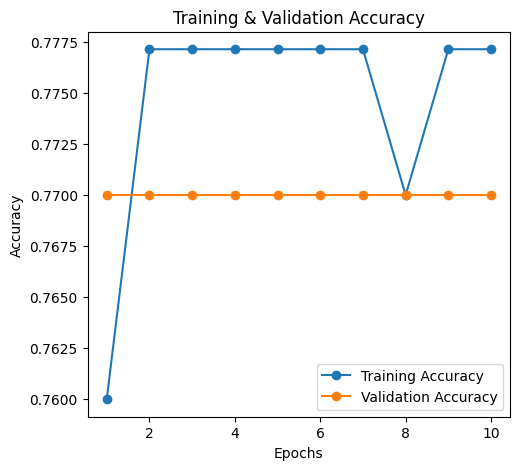

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs_range, valAccuracy, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')

Text(0.5, 1.0, 'Training & Validation Loss')

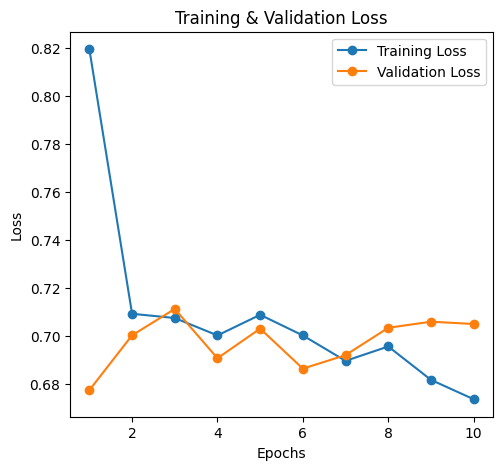

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, valLoss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')

##### overfitting

### OUTPUT VS PREDICTED OUTPUT


In [21]:
predictions=model.predict(padded_sequences)
predictedClasses=np.argmax(predictions,axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step


In [22]:
comparisonData=pd.DataFrame({
    "Text":lmtpData["CombinedText"],
    "Actual Sentiment":lmtpData["Sentiment"].values,
    "Predicted Sentiment":predictedClasses
})
comparisonData.head(10)

,Text,Actual Sentiment,Predicted Sentiment
329374,Best Soup Ever This soup is in a class by itse...,1,1
484157,Absolutely delicious!!! Excellent product- has...,1,1
115845,"Best Cuppa English Tea (In My Book) First off,...",1,1
540486,Delicious coffee I have tried many strengths o...,1,1
536330,best dog food on the market When I first found...,1,1
49178,"Yummiest!! Oh, garibaldi biscuits, how I have ...",1,1
241486,"Blah!!! If you like the taste of cardboard, yo...",0,1
189229,Just okay...not exactly what I hoped for I hav...,2,1
261384,excellent nonfat dessert this is a great optio...,1,1
339998,Fruit Stripe Gum Tastes just like it did when ...,1,1


In [23]:
comparisonData.head(20)

,Text,Actual Sentiment,Predicted Sentiment
329374,Best Soup Ever This soup is in a class by itse...,1,1
484157,Absolutely delicious!!! Excellent product- has...,1,1
115845,"Best Cuppa English Tea (In My Book) First off,...",1,1
540486,Delicious coffee I have tried many strengths o...,1,1
536330,best dog food on the market When I first found...,1,1
49178,"Yummiest!! Oh, garibaldi biscuits, how I have ...",1,1
241486,"Blah!!! If you like the taste of cardboard, yo...",0,1
189229,Just okay...not exactly what I hoped for I hav...,2,1
261384,excellent nonfat dessert this is a great optio...,1,1
339998,Fruit Stripe Gum Tastes just like it did when ...,1,1


## TRAINING USING NEW SAMPLE DATASET

In [24]:
droppedData=dataset.drop(lmtpData.index)
dataset2=droppedData.sample(1000,random_state=43)
dataset2.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150208,150209,B0029JHHO2,A1XINNG3IMIBSR,Jim,0,0,4,1339977600,The artificial taste grew on me,"My wife picked these up for my 4 year old, sin..."
541135,541136,B000FMTJJQ,A1CZZFK4TG9L44,Brent Shellhorse,0,0,5,1197936000,great tasting good for kids,We have started using this instead of sugar an...
480355,480356,B000DZDJ0K,AU4SGJS71ZV55,Charlotta HIbbs,0,0,5,1304380800,Great waffles...,This gluten-free flour mix is great for waffle...
363032,363033,B0049WV8S8,A3BYK09E8ARIFB,"RMB ""pensman""",0,0,5,1350432000,Easier than pan frying,I place a paper towel on the grilling plate an...
555884,555885,B001TLY7BM,A188O75EI73BUH,Molly and Charlie,9,13,1,1324512000,"made in the USA and made in Thailand, do they ...","I have two cats that are very picky eaters, so..."


In [25]:
lmtpData2=dataset2[['Score','Summary','Text']]
lmtpData2.head()

,Score,Summary,Text
150208,4,The artificial taste grew on me,"My wife picked these up for my 4 year old, sin..."
541135,5,great tasting good for kids,We have started using this instead of sugar an...
480355,5,Great waffles...,This gluten-free flour mix is great for waffle...
363032,5,Easier than pan frying,I place a paper towel on the grilling plate an...
555884,1,"made in the USA and made in Thailand, do they ...","I have two cats that are very picky eaters, so..."


In [26]:
lmtpData2 = lmtpData2.copy()
lmtpData2['Summary'] = lmtpData2['Summary'].fillna("")
lmtpData2['CombinedText'] = lmtpData2['Summary'] + " " + lmtpData2['Text']


In [27]:
lmtpData2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 150208 to 28993
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Score         1000 non-null   int64 
 1   Summary       1000 non-null   object
 2   Text          1000 non-null   object
 3   CombinedText  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.1+ KB


In [28]:

lmtpData2['Sentiment']=lmtpData2['Score'].apply(lblScore)
lmtpData2.head(5)

,Score,Summary,Text,CombinedText,Sentiment
150208,4,The artificial taste grew on me,"My wife picked these up for my 4 year old, sin...",The artificial taste grew on me My wife picked...,1
541135,5,great tasting good for kids,We have started using this instead of sugar an...,great tasting good for kids We have started us...,1
480355,5,Great waffles...,This gluten-free flour mix is great for waffle...,Great waffles... This gluten-free flour mix is...,1
363032,5,Easier than pan frying,I place a paper towel on the grilling plate an...,Easier than pan frying I place a paper towel o...,1
555884,1,"made in the USA and made in Thailand, do they ...","I have two cats that are very picky eaters, so...","made in the USA and made in Thailand, do they ...",0


In [29]:
tokenizer.fit_on_texts(lmtpData2['CombinedText'])
sequences=tokenizer.texts_to_sequences(lmtpData2['CombinedText'])

maxLen=100
paddedData=pad_sequences(sequences,maxlen=maxLen,padding='post')
embedding_dim=100
vocabSize=len(tokenizer.word_index) + 1

embeddingMatrix2=np.zeros((vocabSize,embedding_dim))

for word,i in tokenizer.word_index.items():
    embeddingVector2=gloveEmbeddings.get(word)
    if embeddingVector2 is not None:
        embeddingMatrix2[i]=embeddingVector2

### BALANCING THE CLASSES

In [30]:
from imblearn.over_sampling import SMOTE


y2 = lmtpData2['Sentiment'].values


smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(paddedData, y2)


In [31]:
maxLen=100
model = Sequential([
    Input(shape=(maxLen,)),
    Embedding(input_dim=vocabSize,  
              output_dim=embedding_dim, 
              weights=embeddingMatrix2, 
             
              trainable=False), 
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.6),
    Dense(3, activation='softmax') 
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 100)            │         976,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,142,851 (4.36 MB)

 Trainable params: 166,851 (651.76 KB)

 Non-trainable params: 976,000 (3.72 MB)

In [32]:
model.fit(X_resampled, Y_resampled, epochs=6, batch_size=32, validation_split=0.3)

Epoch 1/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 207ms/step - accuracy: 0.4697 - loss: 0.9773 - val_accuracy: 0.0043 - val_loss: 2.4082
Epoch 2/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.5139 - loss: 0.8840 - val_accuracy: 0.0043 - val_loss: 2.8451
Epoch 3/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.4698 - loss: 0.8716 - val_accuracy: 0.0043 - val_loss: 2.5942
Epoch 4/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.5124 - loss: 0.8630 - val_accuracy: 0.0058 - val_loss: 3.1311
Epoch 5/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.5564 - loss: 0.8234 - val_accuracy: 0.0101 - val_loss: 2.8197
Epoch 6/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.5506 - loss: 0.8322 - val_accuracy: 0.0058 - val_loss: 2.8509


In [33]:
model.fit(X_resampled, Y_resampled, epochs=15, batch_size=32, validation_split=0.4)

Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.5738 - loss: 0.8482 - val_accuracy: 0.1130 - val_loss: 2.3129
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.6115 - loss: 0.7935 - val_accuracy: 0.0946 - val_loss: 2.0661
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.6447 - loss: 0.7687 - val_accuracy: 0.0337 - val_loss: 2.5646
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.6591 - loss: 0.7473 - val_accuracy: 0.2424 - val_loss: 2.3554
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.6906 - loss: 0.7168 - val_accuracy: 0.2283 - val_loss: 2.1629
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.7116 - loss: 0.6990 - val_accuracy: 0.1185 - val_loss: 2.4099
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.7205 - loss: 0.6692 - val_accuracy: 0.2348 - val_loss: 2.7780
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.7917 - loss: 0.5622 - val_accuracy: 0

In [34]:
model.fit(X_resampled, Y_resampled, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.6388 - loss: 0.9222 - val_accuracy: 0.0478 - val_loss: 1.3495
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.7994 - loss: 0.5483 - val_accuracy: 0.0261 - val_loss: 1.6137
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.8225 - loss: 0.4660 - val_accuracy: 0.0630 - val_loss: 1.5614
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.8323 - loss: 0.4792 - val_accuracy: 0.0326 - val_loss: 1.4888
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.8410 - loss: 0.4491 - val_accuracy: 0.0652 - val_loss: 1.6255
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.8373 - loss: 0.4412 - val_accuracy: 0.0500 - val_loss: 1.5811
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.8463 - loss: 0.4213 - val_accuracy: 0.1109 - val_loss: 1.3228
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.8545 - loss: 0.3747 - val_accu

### WITHOUT SMOTE

In [35]:
model.fit(paddedData,y2, epochs=15, batch_size=32, validation_split=0.3)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.9564 - loss: 0.1268 - val_accuracy: 0.9567 - val_loss: 0.2092
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.9729 - loss: 0.1254 - val_accuracy: 0.9500 - val_loss: 0.1588
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.9659 - loss: 0.0896 - val_accuracy: 0.9500 - val_loss: 0.2205
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.9745 - loss: 0.0922 - val_accuracy: 0.9733 - val_loss: 0.1639
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.9742 - loss: 0.0887 - val_accuracy: 0.9667 - val_loss: 0.1457
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.9797 - loss: 0.0657 - val_accuracy: 0.9600 - val_loss: 0.1829
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.9701 - loss: 0.1511 - val_accuracy: 0.9567 - val_loss: 0.1765
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9809 - loss: 0.0808 - val_accuracy: 0.

#### PREDICTING DATA


In [36]:
predictedData=model.predict(paddedData)
predClasses=np.argmax(predictedData,axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step


In [37]:
comparisonData2=pd.DataFrame({
    "Text":lmtpData["CombinedText"],
    "Actual Sentiment":lmtpData["Sentiment"].values,
    "Predicted Sentiment":predClasses
})
comparisonData2.head(10)

,Text,Actual Sentiment,Predicted Sentiment
329374,Best Soup Ever This soup is in a class by itse...,1,1
484157,Absolutely delicious!!! Excellent product- has...,1,1
115845,"Best Cuppa English Tea (In My Book) First off,...",1,1
540486,Delicious coffee I have tried many strengths o...,1,1
536330,best dog food on the market When I first found...,1,0
49178,"Yummiest!! Oh, garibaldi biscuits, how I have ...",1,1
241486,"Blah!!! If you like the taste of cardboard, yo...",0,0
189229,Just okay...not exactly what I hoped for I hav...,2,1
261384,excellent nonfat dessert this is a great optio...,1,0
339998,Fruit Stripe Gum Tastes just like it did when ...,1,2


In [38]:
comparisonData2.tail(10)

,Text,Actual Sentiment,Predicted Sentiment
173635,"Skippy Dipping! I love SKIPPY Peanut Butter, e...",1,1
425577,just the right mix Kind fruit and nut bars are...,1,2
526717,Unique and flavorful Someone brought these to ...,1,1
66638,"Yummy, but use quickly The bag is large so mak...",1,1
435630,"YUP, most of cans are dented. yes, most of the...",1,0
564392,Two dogs love it! I have very small dogs (5 an...,1,1
83187,DOOMHAMMER approved I love this brand. If you ...,1,1
112400,Excellent chocolate bar... This bar is unbelie...,1,0
326690,The one decaf I always have I used to have the...,1,0
401509,Fruity and easy to take along :-) These fruit ...,1,1


#### USING A SPECIFIC REVIEW

In [39]:

new_review = "I love this product, it's amazing!"


new_review_tokens = tokenizer.texts_to_sequences([new_review])
new_review_padded = pad_sequences(new_review_tokens, maxlen=maxLen)

predictions = model.predict(new_review_padded)


predicted_class = np.argmax(predictions, axis=1)

print("Predicted Class: ", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Class:  [2]


In [40]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

new_review2 = "This is so terrible.It literally melted my skin"


new_review_tokens2 = tokenizer.texts_to_sequences([new_review2])
new_review_padded2 = pad_sequences(new_review_tokens2, maxlen=maxLen)


predictions = model.predict(new_review_padded2)


predicted_class2 = np.argmax(predictions, axis=1)

print(predicted_class2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[2]
